# 3. Fat Cantor Sets

**Goal:** Construct nowhere-dense sets with positive Lebesgue measure.

## Background

The classical Cantor set is nowhere dense and has measure 0. One might guess these are related —
perhaps "topologically thin" sets must be "measure-theoretically thin." This is **false**.

A **fat Cantor set** (Smith-Volterra-Cantor set) is constructed like the standard Cantor set,
but we remove *shorter* intervals at each stage. By controlling the removal lengths,
we can create a closed, nowhere-dense set with any desired measure $\alpha \in (0, 1)$.

This demonstrates that **measure and topology are fundamentally independent** concepts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Construction

At stage $n$, we have $2^n$ intervals. From each, we remove a centered open interval
of length $\ell_n$. To achieve a final measure of $\alpha$, we need:

$$\sum_{n=0}^{\infty} 2^n \, \ell_n = 1 - \alpha$$

A common choice: remove length $\ell_n = \frac{(1-\alpha)}{2} \cdot \frac{1}{4^n}$ at stage $n$ from each interval,
so total removed $= \sum_{n=0}^\infty 2^n \cdot \frac{(1-\alpha)}{2 \cdot 4^n} = \frac{(1-\alpha)}{2} \sum (1/2)^n = 1 - \alpha$.

In [2]:
def fat_cantor_intervals(target_measure, n_stages):
    """
    Construct a fat Cantor set with the given target measure.
    Returns a list of interval lists, one per stage.
    """
    total_to_remove = 1.0 - target_measure
    stages = [[(0.0, 1.0)]]
    
    for n in range(n_stages):
        prev = stages[-1]
        # Length to remove from each interval at this stage
        removal_per_interval = (total_to_remove / 2.0) / (4.0 ** n)
        new = []
        for a, b in prev:
            interval_len = b - a
            if removal_per_interval >= interval_len:
                # Can't remove more than the interval length; skip
                new.append((a, b))
                continue
            mid = (a + b) / 2
            half_removal = removal_per_interval / 2
            new.append((a, mid - half_removal))
            new.append((mid + half_removal, b))
        stages.append(new)
    
    return stages


# Compare standard Cantor (measure 0) vs fat Cantor (measure 0.5)
def standard_cantor_intervals(n_stages):
    """Standard middle-thirds Cantor set."""
    stages = [[(0.0, 1.0)]]
    for _ in range(n_stages):
        prev = stages[-1]
        new = []
        for a, b in prev:
            third = (b - a) / 3
            new.append((a, a + third))
            new.append((b - third, b))
        stages.append(new)
    return stages

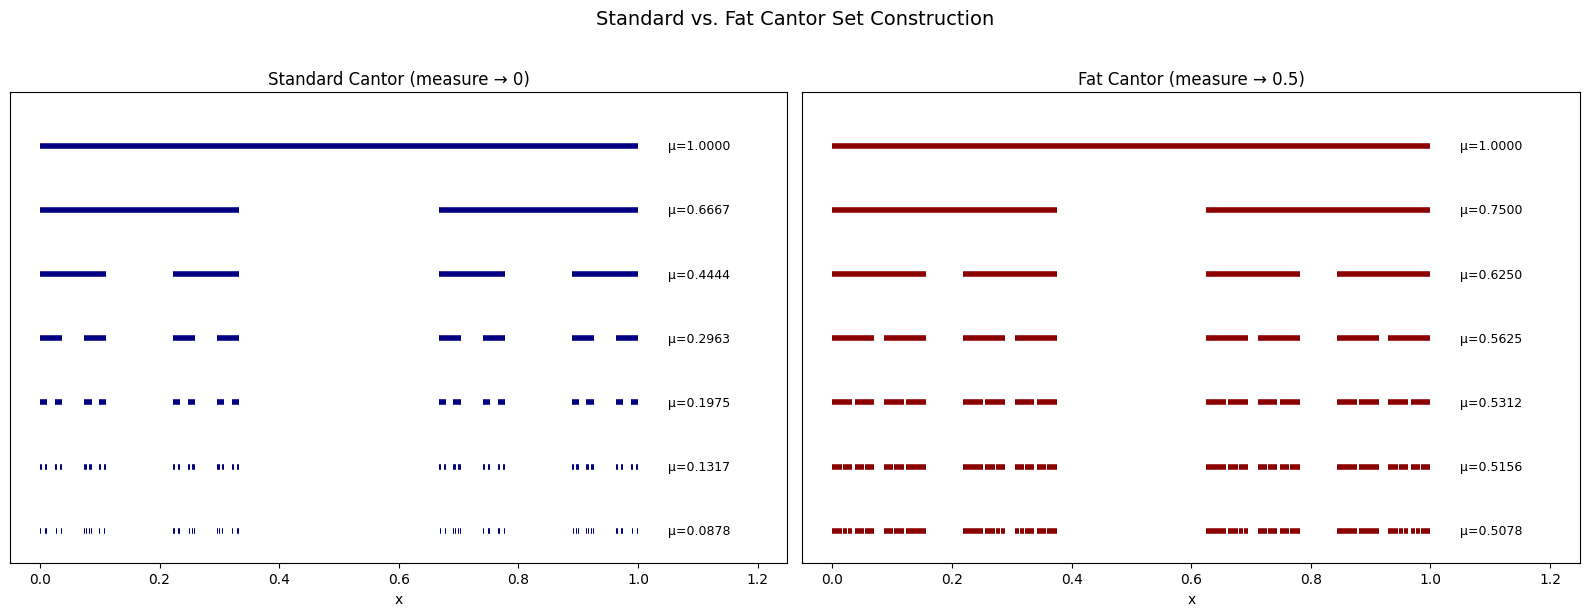

In [3]:
n_stages = 6

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (name, stages_fn, color) in zip(axes, [
    ('Standard Cantor (measure → 0)', lambda: standard_cantor_intervals(n_stages), 'navy'),
    ('Fat Cantor (measure → 0.5)', lambda: fat_cantor_intervals(0.5, n_stages), 'darkred'),
]):
    stages = stages_fn()
    for i, intervals in enumerate(stages):
        y = -i * 0.6
        for a, b in intervals:
            ax.plot([a, b], [y, y], color=color, linewidth=4, solid_capstyle='butt')
        total_len = sum(b - a for a, b in intervals)
        ax.text(1.05, y, f'μ={total_len:.4f}', va='center', fontsize=9)
    ax.set_xlim(-0.05, 1.25)
    ax.set_ylim(-(n_stages + 0.5) * 0.6, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('x')
    ax.set_title(name, fontsize=12)

plt.suptitle('Standard vs. Fat Cantor Set Construction', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Varying the Target Measure

We can create fat Cantor sets with any measure $\alpha \in (0,1)$.
All of them are closed and nowhere dense, yet they can fill up nearly all of $[0,1]$.

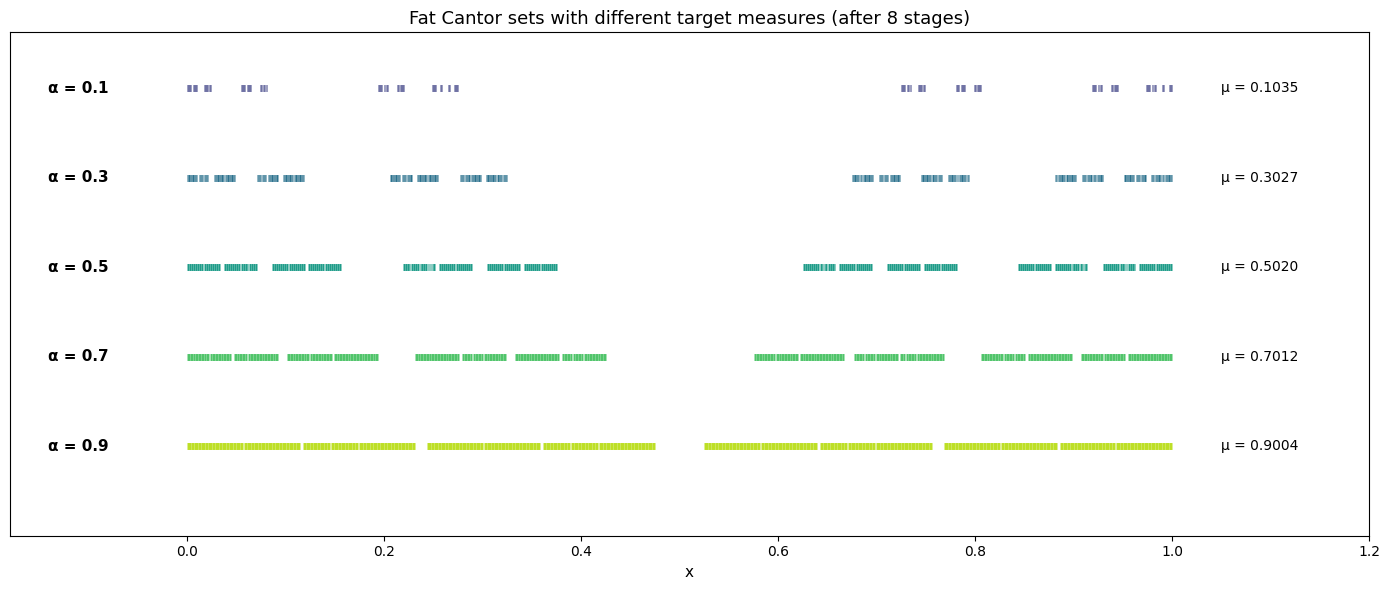

In [4]:
target_measures = [0.1, 0.3, 0.5, 0.7, 0.9]
n_stages = 8

fig, ax = plt.subplots(figsize=(14, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(target_measures)))

for row, (alpha, color) in enumerate(zip(target_measures, colors)):
    stages = fat_cantor_intervals(alpha, n_stages)
    intervals = stages[-1]
    y = -row * 0.8
    for a, b in intervals:
        ax.plot([a, b], [y, y], color=color, linewidth=5, solid_capstyle='butt')
    actual_measure = sum(b - a for a, b in intervals)
    ax.text(-0.08, y, f'α = {alpha}', va='center', ha='right', fontsize=11, fontweight='bold')
    ax.text(1.05, y, f'μ = {actual_measure:.4f}', va='center', fontsize=10)

ax.set_xlim(-0.18, 1.2)
ax.set_ylim(-(len(target_measures)) * 0.8, 0.5)
ax.set_yticks([])
ax.set_xlabel('x', fontsize=11)
ax.set_title(f'Fat Cantor sets with different target measures (after {n_stages} stages)', fontsize=13)
plt.tight_layout()
plt.show()

## Nowhere Dense but Positive Measure

A set is **nowhere dense** if its closure has empty interior — it contains no interval.
Let's verify this numerically: for any small interval $(a, b) \subset [0,1]$,
the fat Cantor set's complement (the removed gaps) always intersects it.

In [5]:
def check_nowhere_dense(intervals, n_test=1000):
    """
    Check that no test interval is fully contained in the set.
    The set is represented by its list of component intervals.
    """
    # Sort intervals
    intervals = sorted(intervals)
    # Find gaps (the removed parts)
    gaps = []
    for i in range(len(intervals) - 1):
        gap_start = intervals[i][1]
        gap_end = intervals[i + 1][0]
        if gap_end > gap_start + 1e-15:
            gaps.append((gap_start, gap_end))
    
    # Test random intervals
    np.random.seed(123)
    contains_gap = 0
    for _ in range(n_test):
        a = np.random.uniform(0, 0.99)
        b = a + np.random.uniform(0.001, 0.05)
        b = min(b, 1.0)
        # Does [a,b] contain any gap?
        for g_start, g_end in gaps:
            if g_start >= a and g_end <= b:
                contains_gap += 1
                break
            if g_start > b:
                break
    return contains_gap, n_test


stages = fat_cantor_intervals(0.5, 12)
intervals = stages[-1]
hits, total = check_nowhere_dense(intervals)
print(f"Nowhere dense test: {hits}/{total} random intervals contain a gap in the complement.")
print(f"(As stages → ∞, this fraction → 1 for any fixed minimum interval width.)")
print(f"\nThe fat Cantor set is NOWHERE DENSE despite having measure 0.5.")

Nowhere dense test: 699/1000 random intervals contain a gap in the complement.
(As stages → ∞, this fraction → 1 for any fixed minimum interval width.)

The fat Cantor set is NOWHERE DENSE despite having measure 0.5.


## Measure vs. Topological Category

This example reveals a deep dichotomy:

| Property | Cantor set (standard) | Fat Cantor set | Dense open set |
|----------|----------------------|----------------|----------------|
| Lebesgue measure | 0 | > 0 (any $\alpha$) | can be < 1 |
| Topologically | nowhere dense | nowhere dense | dense, open |
| Baire category | meager (1st category) | meager | residual |

In fact, one can construct:
- A **meager** (1st category) set of **full measure** — topologically tiny but measure-theoretically huge
- A **residual** (2nd category) set of **measure zero** — topologically huge but measure-theoretically tiny

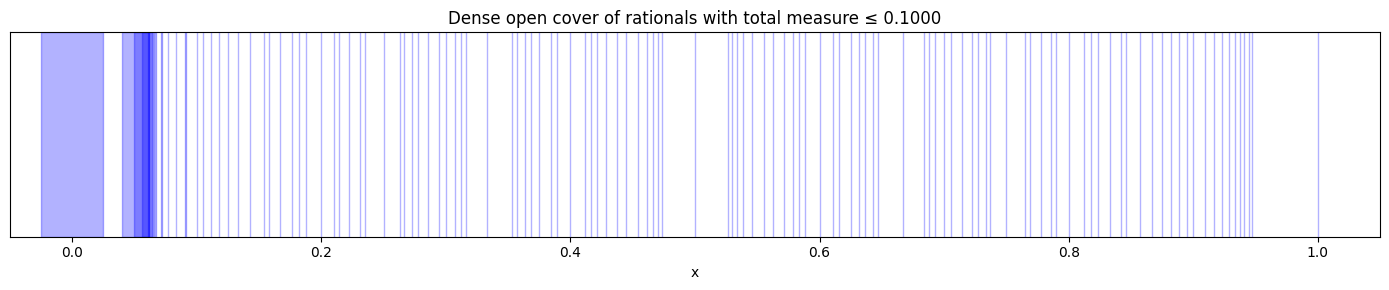

This open set is DENSE (contains all rationals) but has measure ≤ 0.1000
Its complement is NOWHERE DENSE but has measure ≥ 0.9000


In [6]:
# Demonstrate: a dense open set with small measure
# Cover each rational p/q (with small q) by an interval of length epsilon/2^n
epsilon = 0.1
rationals = []
for q in range(1, 20):
    for p in range(q + 1):
        r = p / q
        if 0 <= r <= 1 and r not in [x[0] for x in rationals]:
            rationals.append((r, q))

rationals.sort()
fig, ax = plt.subplots(figsize=(14, 3))

total_cover_length = 0
for n, (r, q) in enumerate(rationals):
    half_width = epsilon / 2**(n + 2)
    total_cover_length += 2 * half_width
    ax.axvspan(r - half_width, r + half_width, alpha=0.3, color='blue')

ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_title(f'Dense open cover of rationals with total measure ≤ {total_cover_length:.4f}', fontsize=12)
ax.set_xlabel('x')
plt.tight_layout()
plt.show()

print(f"This open set is DENSE (contains all rationals) but has measure ≤ {total_cover_length:.4f}")
print(f"Its complement is NOWHERE DENSE but has measure ≥ {1 - total_cover_length:.4f}")

## Key Takeaways

1. **Measure ≠ topology:** A set can be "topologically small" (nowhere dense) yet have positive — even nearly full — measure.
2. **Fat Cantor sets** provide clean counterexamples to naive intuitions about the relationship between measure and density.
3. **Baire category and Lebesgue measure are independent:** first-category sets can have full measure, and residual sets can have measure zero.
4. This independence is fundamental in analysis — many theorems require *both* measure-theoretic and topological hypotheses.